## Importing libraries

In [25]:
import numpy as np
import networkx as nx
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.style.use("science")
from scipy.optimize import linprog
import pandas as pd
import networkx as nx

## Monge formulation

Let $X: \Omega_{X} \rightarrow \mathbb{R}$ and $Y: \Omega_{Y} \rightarrow \mathbb{R}$ be two discrete random variables with $\Omega_{X} = \Omega_{Y} = [1, \ldots, N]$, the Monge formulation of the optimal transport problem is

<font color="blue">
$$ \begin{array}{c}\text{min}\\ \sigma \in \Pi_{N}\end{array}
\left\{ \sum_{i=1}^{N} C_{i},\sigma(i) \right\}$$
</font>

where $\Pi_{N}$ is the set of all the permutation matrices of $\{1, \ldots, N\} \text{x} \{1, \ldots, N\}$, $\sigma \in \Pi_{N}$ a permutation matrix and $\sigma(i)$ the ith row of $\sigma$.

## The Monge fomulation doesn't always have a solution

Suppose there are N bakeries and N cafeterias and a bakery can supply only one cafeteria.
Each bakery produces $x_{i}$ cakes and each cafeteria requires $y_{i}$ cakes s.t. $\sum_{i}x_{i} = \sum_{j} y_{j}$.

In [26]:
N = 6
x = np.array([24., 9., 3., 16., 21., 27.])
y = np.array([3., 23., 18., 26., 16., 14.])

In [27]:
x.sum()

100.0

In [28]:
y.sum()

100.0

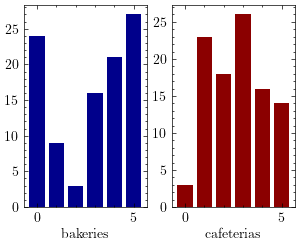

In [29]:
fig, axes = plt.subplots(1, 2);
axes[0].bar(range(N), x, color = "darkblue")
axes[0].set_xlabel("bakeries")
axes[1].bar(range(N), y, color = "darkred", label = "x")
axes[1].set_xlabel("cafeterias")
plt.show()

The problem doesn't have a solution in the Monge formulation. However it can be solved if we relax the constraints and each bakery can supply more than one cafeterias.

## Relaxing the Monge formulation : Kantorovich formulation

Assume that a bakery can deliver cakes to any cafeteria. Now we are interested in finding a matrix $M$ with values in $[0, 1]$ and all the rows and the columns sum to one. $B_{i,j}$ represent the proportion of goods produced by the bakery i and delivered to the cafeteria j.

<font color="blue">
$$M \in \textbf{B}_{N} = \left\{ P \in \mathbb{R}^{N\text{x}N}_{+} : \sum_{i}P_{i,j}=1 \, \sum_{j}P_{i,j}=1 \right\}$$
</font>

where $\textbf{B}_{N}$ is the set of all the bistochastic matrices in $R^{N\text{x}N}$

The kantorovich formulation of the optimal transport problem is

$$
\begin{array}{c} \text{min}\\P \in \textbf{B}_{N}\end{array}
\left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} P_{i,j}C_{i,j}\right\}
$$

Let $P_{ij} = \frac{Z_{ij}}{\sum_{ij} Z_{ij}}$ where $Z \in \textbf{N}^{N\text{x}N}$

$$
\begin{array}{c}
    \begin{array}{c} \text{min}\\P \in \textbf{B}_{N}\end{array}
    \left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} P_{i,j}C_{i,j}\right\}
    &
    \equiv
    \begin{array}{c} \text{min}\\Z \in \textbf{N}^{N\text{x}N}\end{array}
    \left\{ \sum_{i=1}^{N}\sum_{j=1}^{N} Z_{i,j}C_{i,j} : Z_{i,j} \geq 0 \right\}
\end{array}
$$

which can be solved by the following integer linear program 

<font color="blue">
$$
\begin{align}
\text{min} \big\{ <c, z> : p \geq 0, Az = b\big\}
\end{align}
$$
</font>

where c is the vectorized cost matrix C, z is the vectorized matrix Z,
 $A = \left[
\begin{array}{c}
I_{N} \otimes 1_{1\text{x}N}\\
1_{1\text{x}N} \otimes I_{N}
\end{array}
\right]$
and $b=\left[\begin{array}{c}x\\ y \end{array}\right]$

**Solving the problem with scipy**

In [30]:
Ax = np.kron(np.identity(N), np.ones(N))
Ax.shape

(6, 36)

In [31]:
Ay = np.kron(np.ones(N), np.identity(N))
Ay.shape

(6, 36)

In [32]:
A = np.concatenate((Ax, Ay), 0)
A.shape

(12, 36)

In [33]:
b = np.concatenate((x, y))
b.shape

(12,)

In [34]:
C = np.array([[12., 10., 31., 27., 10., 30.],
              [22.,  7., 25., 15., 11., 14.],
              [19.,  7., 19., 10., 15., 15.],
              [10.,  6., 21., 19., 14., 24.],
              [15., 23., 14., 24., 31., 34.],
              [35., 26., 16.,  9., 34., 15.]])
c = C.reshape(N * N)

In [35]:
res = linprog(c, A_eq = A, b_eq = b, method = 'highs')

**Visual checking**

The solution of the integer linear program is 

In [36]:
z = res.x
Z = z.reshape((N, N))

In [37]:
def plot_map(filename = ""):
    fig = plt.figure(figsize=(4, 4))
    gs = GridSpec(2, 2, width_ratios=[1, 5], height_ratios=[1, 5])
    ax1 = plt.subplot(gs[1])
    ax1.bar(range(N), y, color = "darkred")
    ax1.axis("off")
    ax2 = plt.subplot(gs[2])
    ax2.barh(range(N), x, color = "darkblue")
    ax2.invert_xaxis()
    ax2.axis("off")
    ax3 = plt.subplot(gs[3])
    ax3.imshow(Z, cmap = plt.colormaps["Greys"])
    ax3.axis("off")
    for i in range(N):
        for j in range(N):
            color = 'white' if Z[i,j] > 4 else 'grey'
            plt.text(j,i, int(Z[i,j]), horizontalalignment = 'center',
                verticalalignment = 'center', weight = 'bold', color = color)
    if filename != "":
        plt.savefig(filename)
    ax1.set_title("Joint and marginal histograms")
    plt.show()

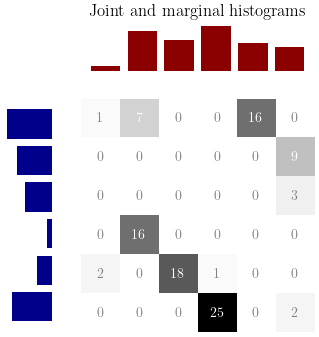

In [38]:
plot_map("../_figures/Joint and marginal histograms")

The bakery 0 should deliver 1 cake to the the cafeteria 0, 7 cakes to the cafeteria 1, 
and 16 cakes to the cafeteria 4.

The bakery 1 should deliver all its 9 cakes to the cafeteria 5, and so on ...

In [39]:
g = nx.Graph()

In [40]:
nodes_x = ['x' + str(i) for i in range(N)]
nodes_y = ['y' + str(i) for i in range(N)]
# Adding the nodes
for n in nodes_x + nodes_y:
    g.add_node(n)
# Adding the edges
for i in range(N):
    for j in range(N):
        if (Z[i, j] > 0):
            g.add_edge(nodes_x[i], nodes_y[j], weight=Z[i,j])

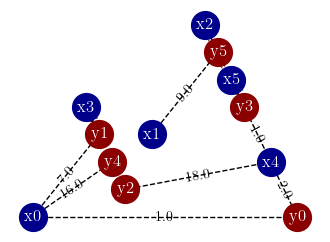

In [41]:
# Drawing the graph
pos = nx.planar_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=nodes_x, node_color = 'darkblue', node_size = 400)
nx.draw_networkx_nodes(g, pos, nodelist=nodes_y, node_color = 'darkred', node_size = 400)
nx.draw_networkx_labels(g, pos, font_color = 'w', font_weight='bold', alpha = 1.0)
edge_labels = nx.get_edge_attributes(g, 'weight')
nx.draw_networkx_edge_labels(g, pos, edge_labels, label_pos=0.5, font_weight='bold')
nx.draw_networkx_edges(g, pos, style = 'dashed')
plt.axis('off')
plt.tight_layout()
plt.show()

The minimum cost is

In [42]:
np.dot(C.flatten(), Z.flatten())

1070.0